In [ ]:
# ============================================
# Install & Import Dependencies
# ============================================
# !pip install scipy pandas

import pandas as pd
import numpy as np
from scipy.io import loadmat
from datetime import datetime, timedelta

# ============================================
# Helper Function: MATLAB datenum → datetime
# ============================================
def matlab2datetime(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum)) \
           + timedelta(days=matlab_datenum % 1) \
           - timedelta(days=366)

# ============================================
# Load .mat Dataset
# ============================================
data = loadmat('/content/drive/MyDrive/assign3/NEUSTG_19502020_12stations.mat')
data_mat=data

lat = data['lattg'].flatten()
lon = data['lontg'].flatten()
sea_level = data['sltg']
station_names = [s[0] for s in data['sname'].flatten()]
time = data['t'].flatten()
time_dt = np.array([matlab2datetime(t) for t in time])

# ============================================
# Select Target Stations
# ============================================
SELECTED_STATIONS = [
    'Annapolis', 'Atlantic_City', 'Charleston', 'Washington', 'Wilmington'
]

selected_idx = [station_names.index(st) for st in SELECTED_STATIONS]
selected_names = [station_names[i] for i in selected_idx]
selected_lat = lat[selected_idx]
selected_lon = lon[selected_idx]
selected_sea_level = sea_level[:, selected_idx]  # time × selected_stations

# ============================================
# Build Preview DataFrame
# ============================================
df_preview = pd.DataFrame({
    'time': np.tile(time_dt[:5], len(selected_names)),
    'station_name': np.repeat(selected_names, 5),
    'latitude': np.repeat(selected_lat, 5),
    'longitude': np.repeat(selected_lon, 5),
    'sea_level': selected_sea_level[:5, :].T.flatten()
})

# ============================================
# Print Data Head
# ============================================
print(f"Number of stations: {len(selected_names)}")
print(f"Sea level shape (time x stations): {selected_sea_level.shape}")
df_preview.head()

Number of stations: 5
Sea level shape (time x stations): (622392, 5)


,time,station_name,latitude,longitude,sea_level
0,1950-01-01 00:00:00.000000,Annapolis,38.98328,-76.4816,1.341
1,1950-01-01 00:59:59.999997,Annapolis,38.98328,-76.4816,1.311
2,1950-01-01 02:00:00.000003,Annapolis,38.98328,-76.4816,1.280
3,1950-01-01 03:00:00.000000,Annapolis,38.98328,-76.4816,1.280
4,1950-01-01 03:59:59.999997,Annapolis,38.98328,-76.4816,1.341


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================
# Convert Hourly → Daily per Station
# ============================================
# Convert time to pandas datetime
time_dt = pd.to_datetime(time_dt)

# Build hourly DataFrame for selected stations
df_hourly = pd.DataFrame({
    'time': np.tile(time_dt, len(selected_names)),
    'station_name': np.repeat(selected_names, len(time_dt)),
    'latitude': np.repeat(selected_lat, len(time_dt)),
    'longitude': np.repeat(selected_lon, len(time_dt)),
    'sea_level': selected_sea_level.flatten()
})

# ============================================
# Compute Flood Threshold per Station
# ============================================
threshold_df = df_hourly.groupby('station_name')['sea_level'].agg(['mean','std']).reset_index()
threshold_df['flood_threshold'] = threshold_df['mean'] + 1.5 * threshold_df['std']

df_hourly = df_hourly.merge(threshold_df[['station_name','flood_threshold']], on='station_name', how='left')

# ============================================
# Daily Aggregation + Flood Flag
# ============================================
df_daily = df_hourly.groupby(['station_name', pd.Grouper(key='time', freq='D')]).agg({
    'sea_level': 'mean',
    'latitude': 'first',
    'longitude': 'first',
    'flood_threshold': 'first'
}).reset_index()

# Flood flag: 1 if any hourly value exceeded threshold that day
hourly_max = df_hourly.groupby(['station_name', pd.Grouper(key='time', freq='D')])['sea_level'].max().reset_index()
df_daily = df_daily.merge(hourly_max, on=['station_name','time'], suffixes=('','_max'))
df_daily['flood'] = (df_daily['sea_level_max'] > df_daily['flood_threshold']).astype(int)

# ============================================
# Feature Engineering (3d & 7d means)
# ============================================
df_daily['sea_level_3d_mean'] = df_daily.groupby('station_name')['sea_level'].transform(
    lambda x: x.rolling(3, min_periods=1).mean())
df_daily['sea_level_7d_mean'] = df_daily.groupby('station_name')['sea_level'].transform(
    lambda x: x.rolling(7, min_periods=1).mean())

# Preview
df_daily.head()

,station_name,time,sea_level,latitude,longitude,flood_threshold,sea_level_max,flood,sea_level_3d_mean,sea_level_7d_mean
0,Annapolis,1950-01-01,1.471958,38.98328,-76.4816,2.396988,2.067,0,1.471958,1.471958
1,Annapolis,1950-01-02,1.455417,38.98328,-76.4816,2.396988,2.505,1,1.463687,1.463687
2,Annapolis,1950-01-03,1.841542,38.98328,-76.4816,2.396988,2.536,1,1.589639,1.589639
3,Annapolis,1950-01-04,1.396750,38.98328,-76.4816,2.396988,1.737,0,1.564569,1.541417
4,Annapolis,1950-01-05,1.704333,38.98328,-76.4816,2.396988,2.292,0,1.647542,1.574000


In [ ]:
# ============================================
# Build 7-day → 14-day Training Windows
# ============================================
FEATURES = ['sea_level', 'sea_level_3d_mean', 'sea_level_7d_mean']
HIST_DAYS = 7
FUTURE_DAYS = 14

X_train, y_train = [], []

for stn, grp in df_daily.groupby('station_name'):
    grp = grp.sort_values('time').reset_index(drop=True)
    for i in range(len(grp) - HIST_DAYS - FUTURE_DAYS):
        hist = grp.loc[i:i+HIST_DAYS-1, FEATURES].values.flatten()
        future = grp.loc[i+HIST_DAYS:i+HIST_DAYS+FUTURE_DAYS-1, 'flood'].values
        X_train.append(hist)
        y_train.append(future)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (129560, 21)
y_train shape: (129560, 14)


In [ ]:
# ============================================
# Select Historical Window (Manual / Random)
# ============================================

# --- Option 1: RANDOM window ---
# np.random.seed(42)
# date_range = pd.date_range(start='1950-01-01', end='2020-12-15')
# hist_start = np.random.choice(date_range)
# hist_end = hist_start + pd.Timedelta(days=6)

# --- Option 2: MANUAL window ---
hist_start = pd.to_datetime('2013-07-21')
hist_end   = pd.to_datetime('2013-07-27')

# Forecast period
test_start = hist_end + pd.Timedelta(days=1)
test_end   = test_start + pd.Timedelta(days=13)

print(f"Historical window: {hist_start.date()} → {hist_end.date()}")
print(f"Forecast window:   {test_start.date()} → {test_end.date()}")

# ============================================
# Build X_test for Selected Window
# ============================================
FEATURES = ['sea_level', 'sea_level_3d_mean', 'sea_level_7d_mean']
X_test = []

for stn, grp in df_daily.groupby('station_name'):
    mask = (grp['time'] >= hist_start) & (grp['time'] <= hist_end)
    hist_block = grp.loc[mask, FEATURES].values.flatten()
    if len(hist_block) == 7 * len(FEATURES):   # ensure full 7-day block
        X_test.append(hist_block)

X_test = np.array(X_test)
print(f"X_test shape: {X_test.shape}  (stations × {7*len(FEATURES)} features)")

Historical window: 2013-07-21 → 2013-07-27
Forecast window:   2013-07-28 → 2013-08-10
X_test shape: (5, 21)  (stations × 21 features)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef
import pickle

# ============================================
# Train 14 XGBoost Models (1 per forecast day)
# ============================================
models = []
for d in range(14):
    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train[:, d])
    models.append(model)

# Save the model
with open("xgb_models.pkl", "wb") as f:
    pickle.dump(models, f)

# ============================================
# Forecast 14 Days Ahead
# ============================================
y_pred = np.array([m.predict(X_test) for m in models]).T
y_pred_bin = (y_pred > 0.5).astype(int)

# ============================================
# Collect Ground Truth
# ============================================
y_true = []
for stn, grp in df_daily.groupby('station_name'):
    mask = (grp['time'] >= test_start) & (grp['time'] <= test_end)
    vals = grp.loc[mask, 'flood'].values
    if len(vals) == 14:
        y_true.append(vals)
y_true = np.array(y_true)

# ============================================
# Evaluation
# ============================================
y_true_flat = y_true.flatten()
y_pred_flat = y_pred_bin.flatten()

tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat).ravel()
acc = accuracy_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
mcc = matthews_corrcoef(y_true_flat, y_pred_flat)

print("=== Confusion Matrix ===")
print(f"TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}")
print("\n=== Metrics ===")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"MCC: {mcc:.3f}")

=== Confusion Matrix ===
TP: 32 | FP: 8 | TN: 24 | FN: 6

=== Metrics ===
Accuracy: 0.800
F1 Score: 0.821
MCC: 0.596


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef
import numpy as np

### Reshaping Data for LSTM



In [ ]:
# Determine number of features per day
num_features_per_day = len(FEATURES)

# Reshape X_train
X_train_reshaped = X_train.reshape(X_train.shape[0], HIST_DAYS, num_features_per_day)

# Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0], HIST_DAYS, num_features_per_day)

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")

X_train_reshaped shape: (129560, 7, 3)
X_test_reshaped shape: (5, 7, 3)


### Define and Train LSTM Model



In [ ]:
lstm_models = []

for d in range(FUTURE_DAYS):
    print(f"Training LSTM model for day {d+1}...")
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(HIST_DAYS, num_features_per_day)),
        Dropout(0.2),
        Dense(1, activation='sigmoid') # Binary classification for each day
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_reshaped, y_train[:, d], epochs=10, batch_size=32, verbose=0) # verbose=0 to reduce output
    lstm_models.append(model)

print("All LSTM models trained.")

Training LSTM model for day 1...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM model for day 2...
Training LSTM model for day 3...
Training LSTM model for day 4...
Training LSTM model for day 5...
Training LSTM model for day 6...
Training LSTM model for day 7...
Training LSTM model for day 8...
Training LSTM model for day 9...
Training LSTM model for day 10...
Training LSTM model for day 11...
Training LSTM model for day 12...
Training LSTM model for day 13...
Training LSTM model for day 14...
All LSTM models trained.


### Forecast 14 Days Ahead with LSTM Models

After training, I will use the LSTM models to predict flood probabilities for each of the 14 future days for the `X_test` data.

In [ ]:
y_pred_lstm = np.array([m.predict(X_test_reshaped).flatten() for m in lstm_models]).T
y_pred_lstm_bin = (y_pred_lstm > 0.5).astype(int)

print(f"y_pred_lstm shape: {y_pred_lstm.shape}")
print(f"y_pred_lstm_bin shape: {y_pred_lstm_bin.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
y_pred_lstm shape: (5, 14)
y_pred_lstm_bin shape: (5, 14)


### Evaluation of LSTM Model

Now, I will evaluate the performance of the LSTM model using the same metrics as before (Confusion Matrix, Accuracy, F1 Score, MCC) by comparing `y_pred_lstm_bin` with the ground truth `y_true`.

In [ ]:
y_true_flat = y_true.flatten()
y_pred_lstm_flat = y_pred_lstm_bin.flatten()

tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_lstm_flat).ravel()
acc_lstm = accuracy_score(y_true_flat, y_pred_lstm_flat)
f1_lstm = f1_score(y_true_flat, y_pred_lstm_flat)
mcc_lstm = matthews_corrcoef(y_true_flat, y_pred_lstm_flat)

print("=== LSTM Confusion Matrix ===")
print(f"TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}")
print("\n=== LSTM Metrics ===")
print(f"Accuracy: {acc_lstm:.3f}")
print(f"F1 Score: {f1_lstm:.3f}")
print(f"MCC: {mcc_lstm:.3f}")

=== LSTM Confusion Matrix ===
TP: 32 | FP: 8 | TN: 24 | FN: 6

=== LSTM Metrics ===
Accuracy: 0.800
F1 Score: 0.821
MCC: 0.596


## Create an alternate Zip Archive



In [ ]:
import zipfile
import os

# Define the list of files to be included in the archive
files_to_archive = [
    'requirements.txt',
    'model.py',
    'model.pkl',
    'predictions.csv',
    'README.md'
]

# Create a ZipFile object with a different name, e.g., 'artifacts_v2.zip'
with zipfile.ZipFile('artifacts_v2.zip', 'w') as zipf:
    # Iterate through the list of files and add each file to the new zip archive
    for file in files_to_archive:
        if os.path.exists(file):
            zipf.write(file)
        else:
            print(f"Warning: File {file} not found and will not be added to the archive.")

print("Archive artifacts_v2.zip created successfully.")

Archive artifacts_v2.zip created successfully.


## Generate requirements.txt



In [ ]:
%%writefile requirements.txt
pandas
numpy
scipy
xgboost
scikit-learn
tensorflow

Writing requirements.txt


## Generate model.py




In [ ]:
%%writefile model.py
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pickle

def matlab2datetime(matlab_datenum):
    """
    Converts MATLAB datenum format to Python datetime objects.
    """
    return datetime.fromordinal(int(matlab_datenum)) \
           + timedelta(days=matlab_datenum % 1) \
           - timedelta(days=366)

def build_lstm_model(input_shape, output_units=1):
    """
    Constructs and compiles a Sequential LSTM model.

    Args:
        input_shape (tuple): The shape of the input data (timesteps, features).
        output_units (int): The number of output units (e.g., 1 for binary classification).

    Returns:
        tf.keras.models.Sequential: A compiled LSTM model.
    """
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(output_units, activation='sigmoid') # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def load_lstm_models(filepath):
    """
    Loads a list of pre-trained Keras LSTM models from a pickle file.

    Args:
        filepath (str): The path to the pickle file containing the models.

    Returns:
        list: A list of loaded Keras LSTM models.
    """
    with open(filepath, 'rb') as f:
        models = pickle.load(f)
    return models


Writing model.py


## Save LSTM Models to model.pkl



In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(lstm_models, f)

print("LSTM models saved to model.pkl")

LSTM models saved to model.pkl


## Generate prediction.csv




In [ ]:
import pandas as pd
import numpy as np

# 1. Create a date range for the 14 forecast days
forecast_dates = pd.date_range(start=test_start, end=test_end)

# 2. Create an empty list to store the prediction records.
prediction_records = []

# 3. Iterate through each station and its corresponding predictions
for i, station_name in enumerate(selected_names):
    for d in range(FUTURE_DAYS):
        record = {
            'station_name': station_name,
            'forecast_date': forecast_dates[d].strftime('%Y-%m-%d'), # Format date for clarity
            'flood_prediction': y_pred_lstm_bin[i, d]
        }
        prediction_records.append(record)

# 4. Convert the list of records into a pandas DataFrame.
df_predictions = pd.DataFrame(prediction_records)

# 5. Save the DataFrame to a CSV file named `predictions.csv` without including the index.
df_predictions.to_csv('predictions.csv', index=False)

print("predictions.csv generated successfully.")
df_predictions.head()

predictions.csv generated successfully.


,station_name,forecast_date,flood_prediction
0,Annapolis,2013-07-28,0
1,Annapolis,2013-07-29,1
2,Annapolis,2013-07-30,1
3,Annapolis,2013-07-31,1
4,Annapolis,2013-08-01,1


## Generate README.md



In [ ]:
%%writefile README.md
# Sea Level Flood Prediction

## Project Overview
This project aims to predict sea level floods for selected coastal stations over a 14-day forecast horizon. It utilizes historical sea level data to identify potential flood events, providing valuable insights for preparedness and risk management.

## Models Used
Two primary machine learning models were developed and evaluated for this flood prediction task:

1.  **XGBoost Regressor**: A gradient boosting model trained to predict flood occurrences for each of the 14 future days.
2.  **LSTM (Long Short-Term Memory) Neural Network**: A recurrent neural network designed for sequence prediction, trained to forecast flood probabilities for the upcoming 14 days.

Both models use historical 7-day sea level features (sea level, 3-day mean, 7-day mean) to predict binary flood events (1 if flood, 0 if no flood).

## How to Use
To utilize the models and interpret the predictions generated by this project, follow the instructions below:

### 1. Install Dependencies
All required Python packages can be installed using the `requirements.txt` file:

```bash
pip install -r requirements.txt
```

### 2. Load Pre-trained LSTM Models
The trained LSTM models are serialized in `model.pkl`. You can load them using the `load_lstm_models` function provided in `model.py`:

```python
from model import load_lstm_models

# Load the list of 14 LSTM models
lstm_models = load_lstm_models('model.pkl')

# You can then use these models to make new predictions
# For example, to predict for an X_test_reshaped data:
# predictions = [model.predict(X_test_reshaped).flatten() for model in lstm_models]
```

### 3. Understand `prediction.csv`
The `prediction.csv` file contains the binary flood predictions generated by the LSTM model for the selected historical window (2013-07-21 to 2013-07-27), forecasting for the 14 days following this period (2013-07-28 to 2013-08-10).

Each row in `prediction.csv` represents a specific station and a forecast date, indicating whether a flood is predicted for that day:

-   `station_name`: The name of the coastal station.
-   `forecast_date`: The specific date for which the flood prediction is made.
-   `flood_prediction`: A binary value (0 or 1), where 1 indicates a predicted flood event and 0 indicates no predicted flood.

Writing README.md


## Create Zip Archive




In [ ]:
import zipfile
import os

# Rename prediction.csv to predictions.csv
# This is done to match the expected filename by the scoring script.
if os.path.exists('prediction.csv'):
    os.rename('prediction.csv', 'predictions.csv')
    print("Renamed 'prediction.csv' to 'predictions.csv'")

# Define the list of files to be included in the archive
files_to_archive = [
    'requirements.txt',
    'model.py',
    'model.pkl',
    'predictions.csv',
    'README.md'
]

# Create a ZipFile object named 'artifacts.zip' in write mode
with zipfile.ZipFile('artifacts.zip', 'w') as zipf:
    # Iterate through the list of files and add each file to the zip archive
    for file in files_to_archive:
        zipf.write(file)

print("Archive artifacts.zip created successfully.")

Renamed 'prediction.csv' to 'predictions.csv'
Archive artifacts.zip created successfully.


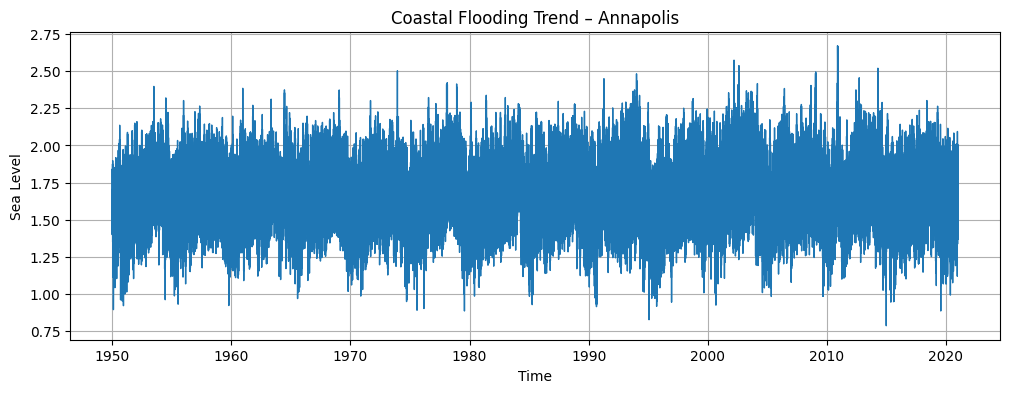

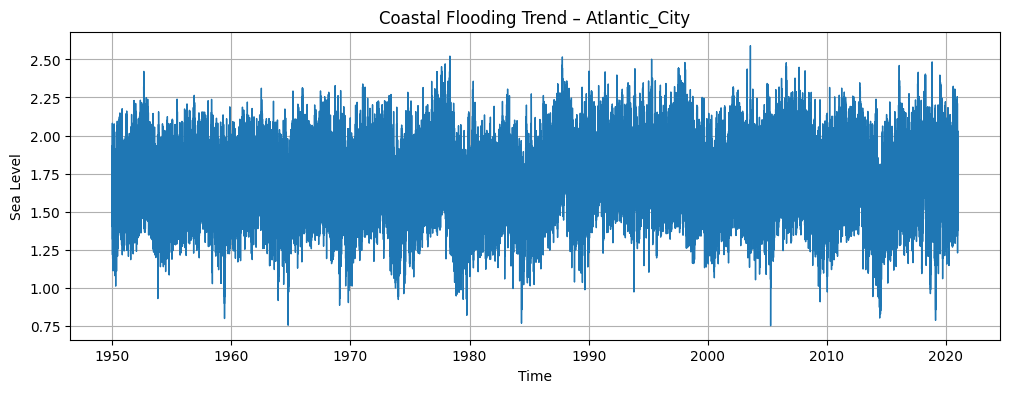

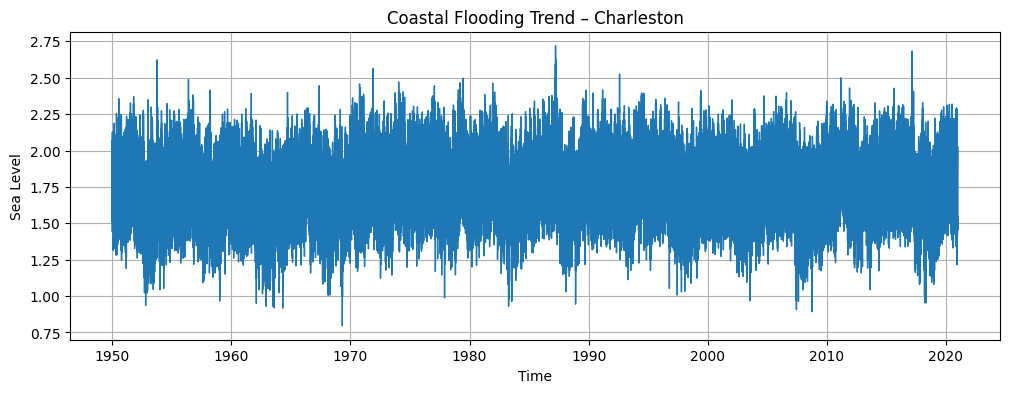

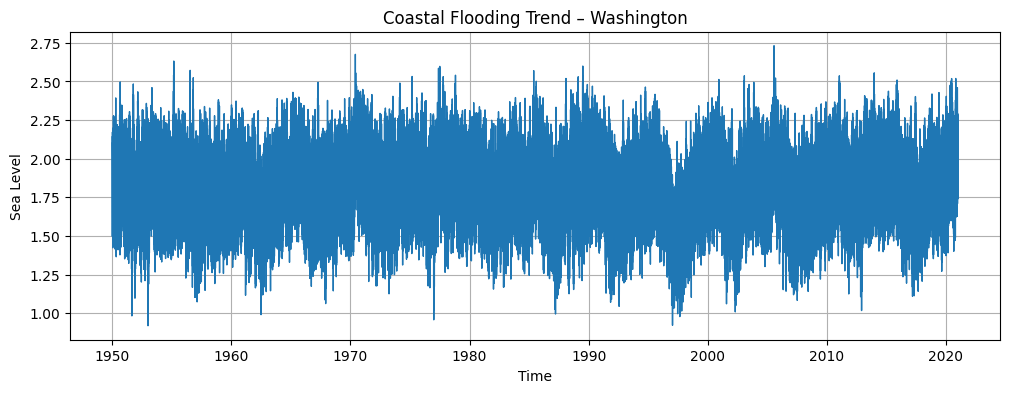

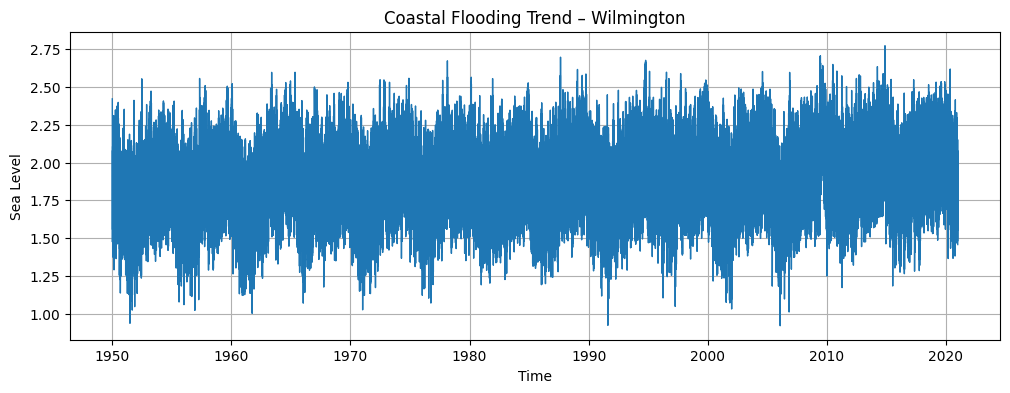

In [ ]:
import matplotlib.pyplot as plt
df=df_daily
for station in df['station_name'].unique():
    station_df = df[df['station_name'] == station]

    plt.figure(figsize=(12,4))
    plt.plot(station_df['time'], station_df['sea_level'], linewidth=1)
    plt.title(f"Coastal Flooding Trend – {station}")
    plt.xlabel("Time")
    plt.ylabel("Sea Level")
    plt.grid(True)
    plt.show()


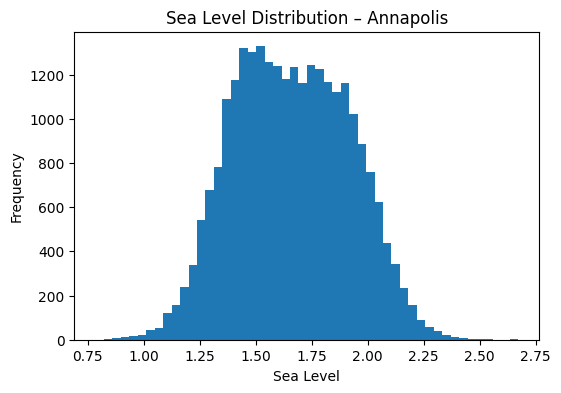

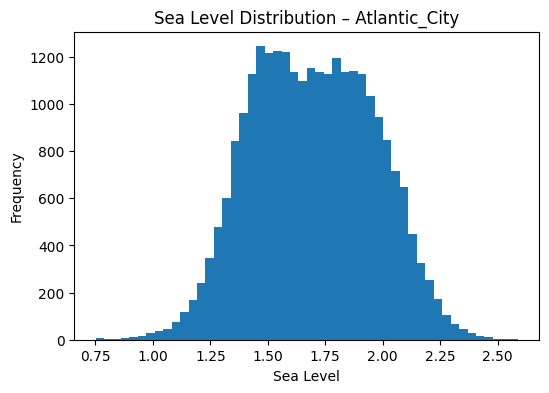

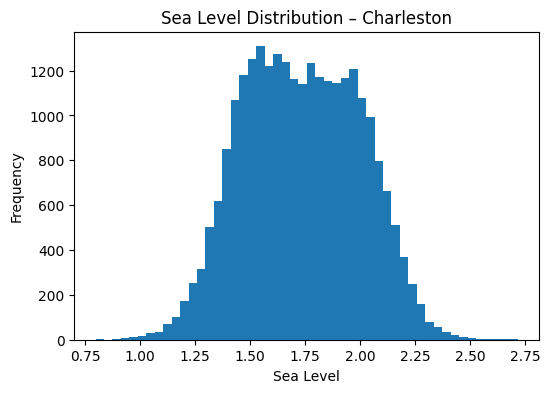

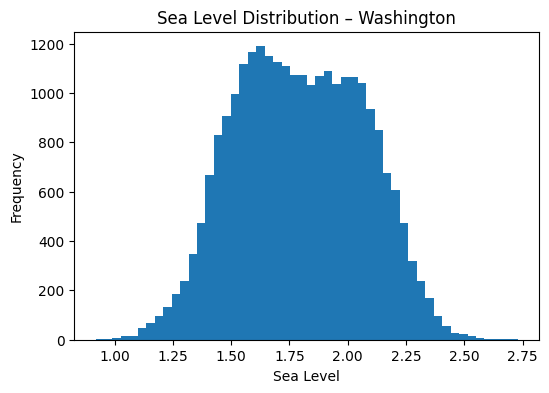

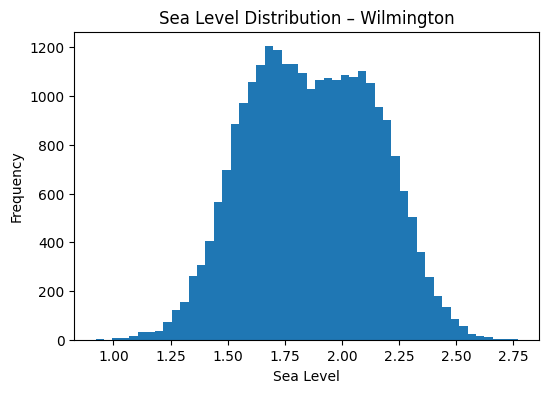

In [ ]:
for station in df['station_name'].unique():
    station_df = df[df['station_name'] == station]

    plt.figure(figsize=(6,4))
    plt.hist(station_df['sea_level'], bins=50)
    plt.title(f"Sea Level Distribution – {station}")
    plt.xlabel("Sea Level")
    plt.ylabel("Frequency")
    plt.show()


<Figure size 1000x500 with 0 Axes>

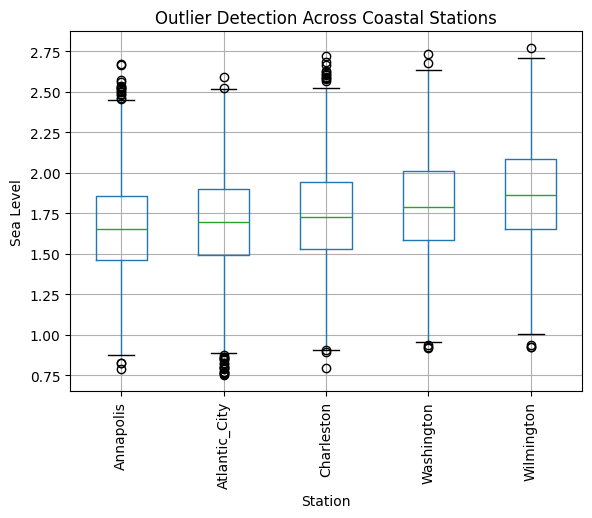

In [ ]:
plt.figure(figsize=(10,5))
df.boxplot(column='sea_level', by='station_name', rot=90)
plt.title("Outlier Detection Across Coastal Stations")
plt.suptitle("")
plt.xlabel("Station")
plt.ylabel("Sea Level")
plt.show()


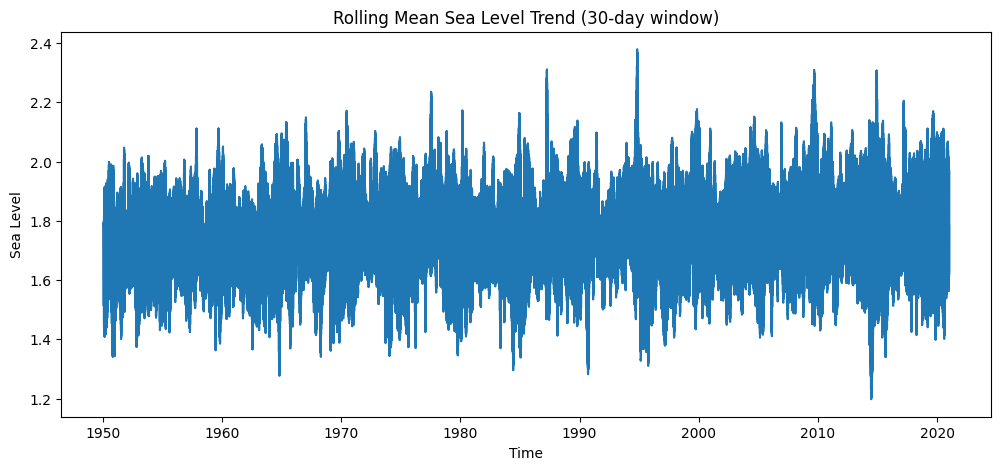

In [ ]:
df_sorted = df.sort_values('time')
df_sorted['rolling_mean'] = (
    df_sorted.groupby('station_name')['sea_level']
    .transform(lambda x: x.rolling(30).mean())
)

plt.figure(figsize=(12,5))
plt.plot(df_sorted['time'], df_sorted['rolling_mean'])
plt.title("Rolling Mean Sea Level Trend (30-day window)")
plt.xlabel("Time")
plt.ylabel("Sea Level")
plt.show()


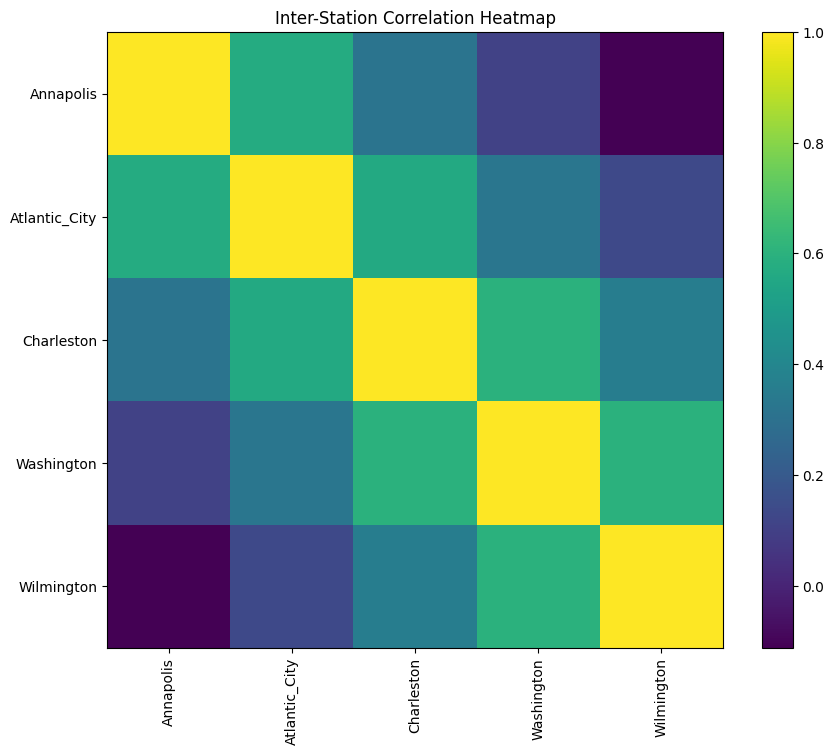

In [ ]:
pivot_df = df.pivot(index='time', columns='station_name', values='sea_level')
corr = pivot_df.corr()

plt.figure(figsize=(10,8))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Inter-Station Correlation Heatmap")
plt.show()


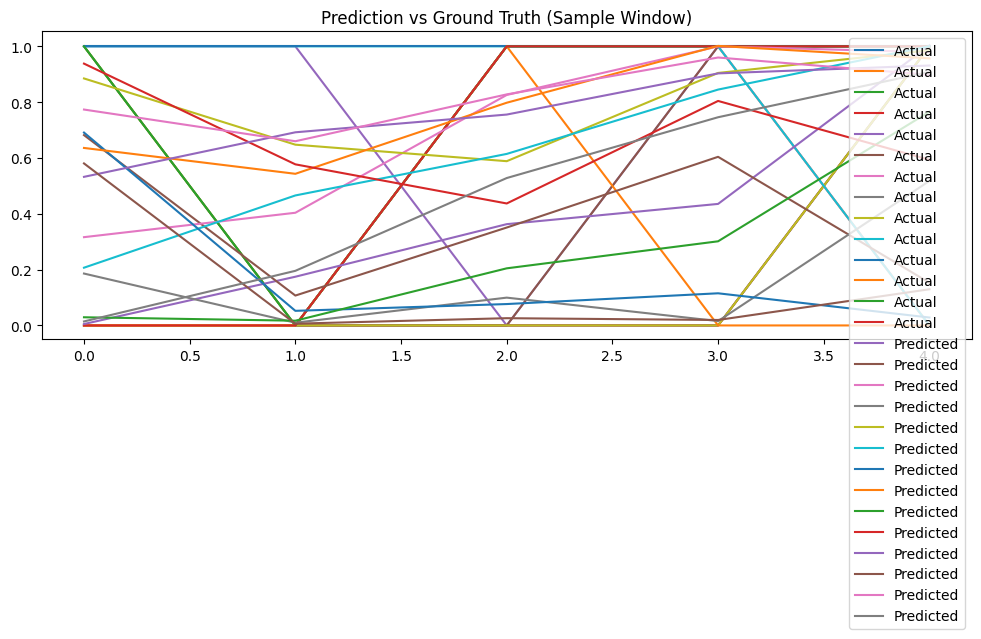

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_true[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.legend()
plt.title("Prediction vs Ground Truth (Sample Window)")
plt.show()


## Final Task

### Subtask:
Confirm the successful creation and delivery of the zip file containing all requested components.
